In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

## ARIMA and SARIMA of Frequency of Tornados

In [4]:
combined_df = pd.read_csv('..\\DATA\\combined_data.csv')
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')
filtered_df = combined_df

tornado_frequency = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH']).size()


C:\Users\zaidf\AppData\Local\Temp\ipykernel_3620\3529462371.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('..\\DATA\\combined_data.csv')


In [4]:
#Test to ensure that data is stationary
freq = pd.DataFrame(tornado_frequency)
freq.columns = ['Value']
result = adfuller(freq['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#P-value < 0.05, fail to reject hypothesis that it is stationary

ADF Statistic: -4.221261653409378
p-value: 0.0006063734741785198


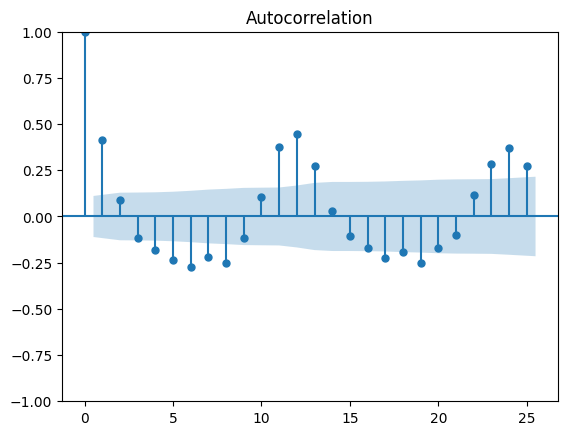

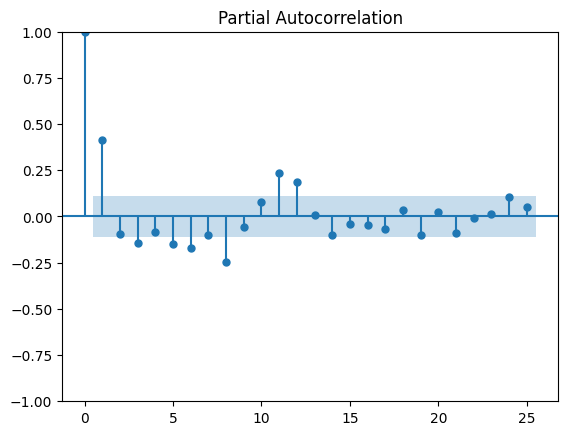

In [5]:
#Plot ACF and PACF to determine order of AR and MA
plot_acf(freq)
plot_pacf(freq)
plt.show()

In [6]:
#80/20 train/test split
train=freq.iloc[:-60]
test=freq.iloc[-60:]
print(train.shape, test.shape)

(251, 1) (60, 1)


In [7]:
#Fit Model and create range for predictions
model = ARIMA(train['Value'], order=(12, 1, 11))
model_fit = model.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_fit.predict(start=start, end=end, typ='levels')

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python311\Lib\site-packages\statsmodels\base\model.p

8891.651718222105

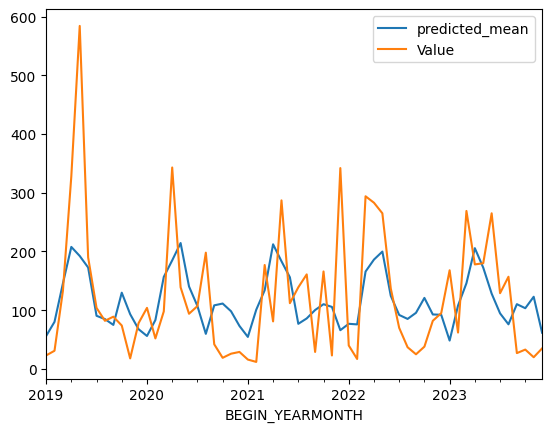

In [8]:
#ARIMA predictions vs actual values. MSE of 9380.02
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

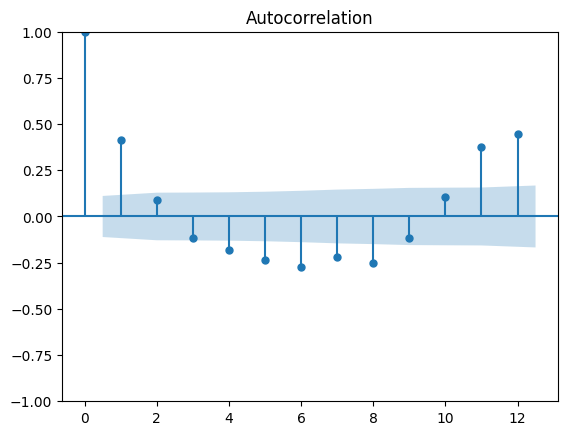

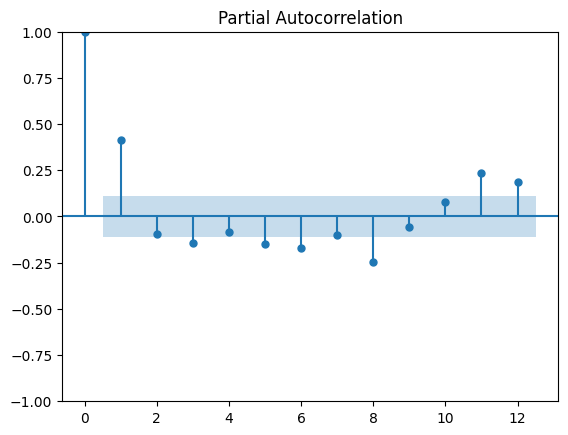

In [9]:
##Plot ACF and PACF to determine order of AR and MA
plot_acf(freq, lags = 12)
plot_pacf(freq, lags = 12)
plt.show()

In [10]:
#Fit Model and create range for predictions, using the same range for train / test
model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')



c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarn

7831.572017350284

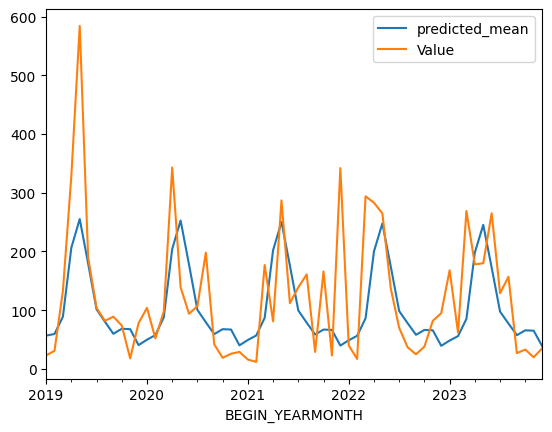

In [11]:
#SARIMA predictions vs actual values. MSE of 8051.06
#Substantially preferred to ARIMA, better at capturing seasonality
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

## ARIMA and SARIMA of Damage of Tornados

In [31]:
combined_df = pd.read_csv('..\\DATA\\combined_data.csv')
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')
filtered_df = combined_df

def convert_damage_to_millions(value):
    if isinstance(value, str):
        value = value.strip()  
        if value == '': 
            return None  
        if 'M' in value: 
            value = value.replace('M', '').strip()
            if value == '': 
                return None 
            return float(value) * 1_000_000
        elif 'K' in value:
            value = value.replace('K', '').strip()
            if value == '': 
                return None 
            return float(value) * 1_000
        else:
            try:
                return float(value)  
            except ValueError:
                return None 
    elif isinstance(value, (int, float)):
        return value
    else:
        return None  

import pandas as pd

def calculate_tornado_damage(df):
    df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage_to_millions)
    df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].fillna(0)
    
    tornado_damage = df.groupby('BEGIN_YEARMONTH')['DAMAGE_PROPERTY'].sum()
    return tornado_damage

tornado_damage = calculate_tornado_damage(filtered_df)
print(tornado_damage)

BEGIN_YEARMONTH
1998-01-01      5066200.0
1998-02-01    346242000.0
1998-03-01    310887000.0
1998-04-01    505523100.0
1998-05-01    353590000.0
                 ...     
2023-08-01     98353000.0
2023-09-01       343500.0
2023-10-01      1626000.0
2023-11-01      1577500.0
2023-12-01     62596000.0
Name: DAMAGE_PROPERTY, Length: 311, dtype: float64


C:\Users\zaidf\AppData\Local\Temp\ipykernel_15952\339732319.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('..\\DATA\\combined_data.csv')


In [28]:
from statsmodels.tsa.stattools import adfuller

damage = pd.DataFrame(tornado_damage)
damage.columns = ['Value']
result = adfuller(damage['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -3.7183416551227815
p-value: 0.003862435598316164


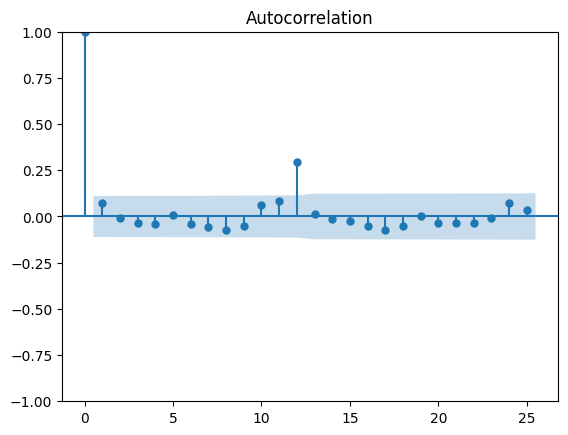

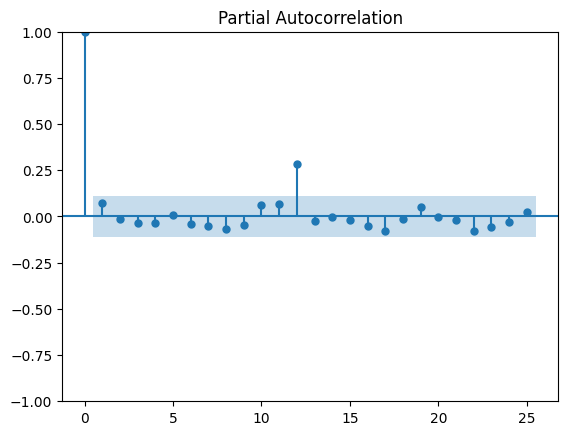

In [29]:
plot_acf(damage)
plot_pacf(damage)
plt.show()

In [30]:
#80/20 train/test split
train=damage.iloc[:-60]
test=damage.iloc[-60:]
print(train, test)
print(train.shape, test.shape)

                       Value
BEGIN_YEARMONTH             
1998-01-01         5066200.0
1998-02-01       346242000.0
1998-03-01       310887000.0
1998-04-01       505523100.0
1998-05-01       353590000.0
...                      ...
2018-08-01         8159000.0
2018-09-01         7865100.0
2018-10-01         6860500.0
2018-11-01        19575000.0
2018-12-01       127303000.0

[251 rows x 1 columns]                        Value
BEGIN_YEARMONTH             
2019-01-01         2280000.0
2019-02-01         4405000.0
2019-03-01        22784000.0
2019-04-01       128208000.0
2019-05-01       847925000.0
2019-06-01         9130000.0
2019-07-01        11526500.0
2019-08-01         8935000.0
2019-09-01        19759000.0
2019-10-01       451813000.0
2019-11-01          555000.0
2019-12-01        33177000.0
2020-01-01        23829000.0
2020-02-01        24870000.0
2020-03-01       825300000.0
2020-04-01       478103000.0
2020-05-01         4054000.0
2020-06-01         1833000.0
2020-07-01         

In [34]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Value'], order=(12, 1, 11))
model_fit = model.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_fit.predict(start=start, end=end, typ='levels')

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py

3.578824565796179e+16

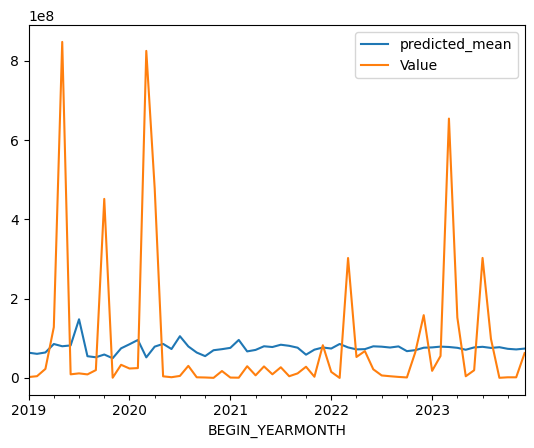

In [35]:
from sklearn.metrics import mean_squared_error

pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

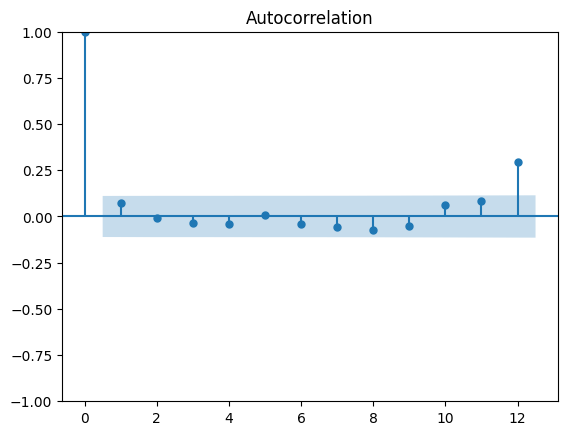

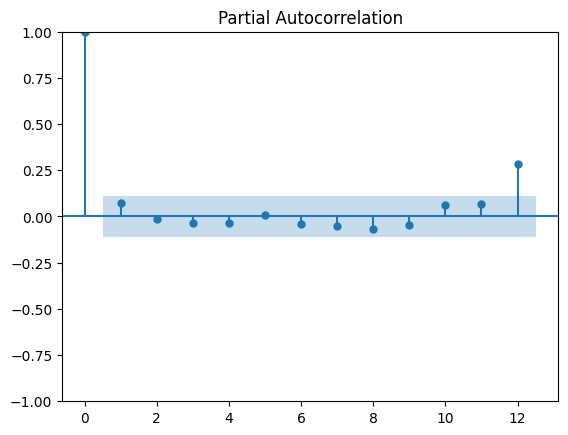

In [18]:
##Plot ACF and PACF to determine order of AR and MA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(damage, lags = 12)
plot_pacf(damage, lags = 12)
plt.show()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')



c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python311\Lib\site-packages\statsm

3.603773591492816e+16

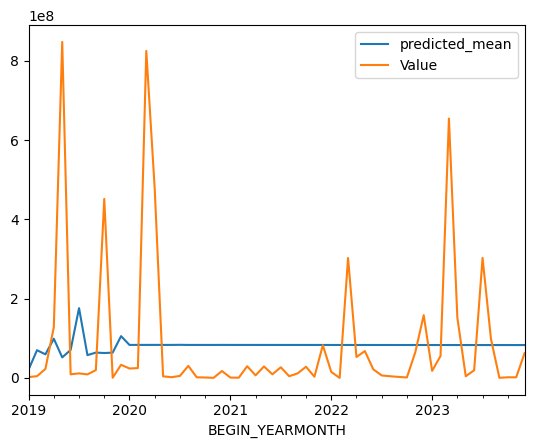

In [20]:
#SARIMA predictions vs actual values. MSE of 8051.06
#Substantially preferred to ARIMA, better at capturing seasonality
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

## ARIMA AND SARIMA FOR VIOLENT TORNADO FREQUENCY

In [9]:
violent_tornadoes = filtered_df[filtered_df['TOR_F_SCALE'].isin(['F3', 'F4', 'F5', 'EF3', 'EF4', 'EF5'])]

violent_tornado_frequency = violent_tornadoes.groupby('BEGIN_YEARMONTH').size()

violent_freq = pd.DataFrame(violent_tornado_frequency)
violent_freq.columns = ['Value']
result = adfuller(violent_freq['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -12.108339242767011
p-value: 1.9453522617214106e-22


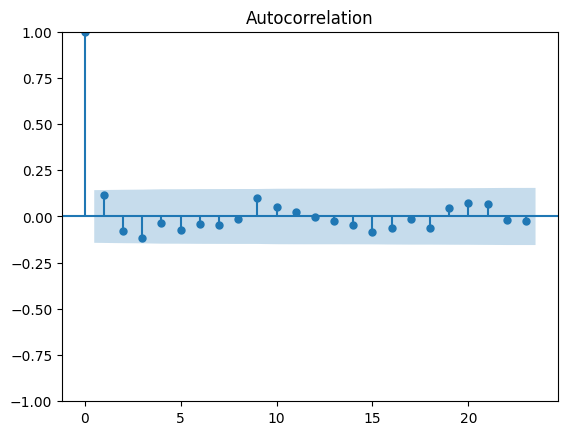

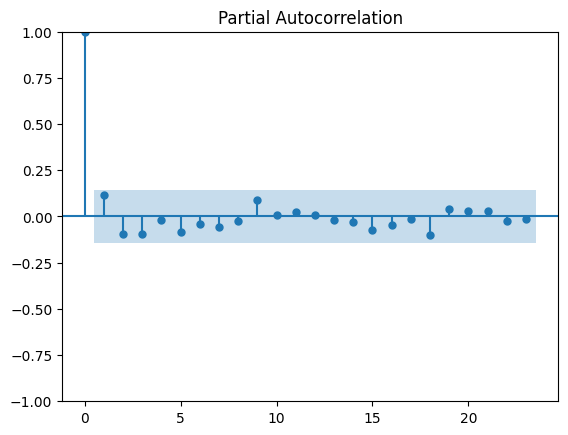

In [10]:
plot_acf(violent_freq)
plot_pacf(violent_freq)
plt.show()

In [28]:
train=violent_tornado_frequency.iloc[:-60]
test=violent_tornado_frequency.iloc[-60:]
print(train.shape, test.shape)
print(train, test)

(129,) (60,)
BEGIN_YEARMONTH
1998-02-01     6
1998-03-01    10
1998-04-01    18
1998-05-01    18
1998-06-01     6
              ..
2013-11-01    11
2014-04-01    15
2014-05-01     7
2014-06-01    11
2014-07-01     2
Length: 129, dtype: int64 BEGIN_YEARMONTH
2014-12-01     1
2015-04-01     2
2015-05-01     8
2015-06-01     4
2015-07-01     1
2015-11-01     4
2015-12-01    13
2016-02-01     5
2016-05-01    15
2016-06-01     1
2016-07-01     1
2016-08-01     3
2016-10-01     1
2016-11-01     3
2017-01-01     7
2017-02-01     9
2017-03-01     1
2017-04-01     3
2017-05-01     2
2018-03-01     1
2018-04-01     1
2018-05-01     1
2018-06-01     4
2018-07-01     3
2018-12-01     2
2019-02-01     1
2019-03-01     4
2019-04-01     9
2019-05-01    24
2019-08-01     1
2019-09-01     1
2019-10-01     1
2019-12-01     7
2020-03-01     4
2020-04-01    24
2020-05-01     1
2020-07-01     2
2020-08-01     1
2021-01-01     1
2021-02-01     1
2021-03-01     7
2021-04-01     2
2021-06-01     2
2021-07-01 

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python311\Lib\site-packages\statsmo

Mean Squared Error: 48.55815854596765


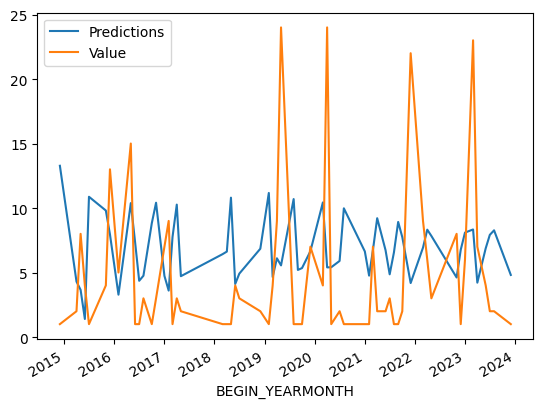

In [29]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
train = train.to_frame(name='Value')
test = test.to_frame(name='Value')
model = ARIMA(train['Value'], order=(12, 1, 11))
model_fit = model.fit()

start = len(train)
end = len(train) + len(test) - 1

pred = model_fit.predict(start=start, end=end, typ='levels')

pred.index = test.index
pred.plot(legend=True, label='Predictions')
test['Value'].plot(legend=True)

mse = mean_squared_error(test['Value'], pred)
print(f'Mean Squared Error: {mse}')


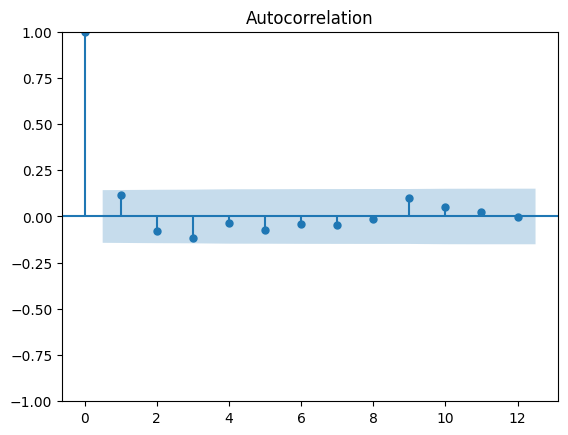

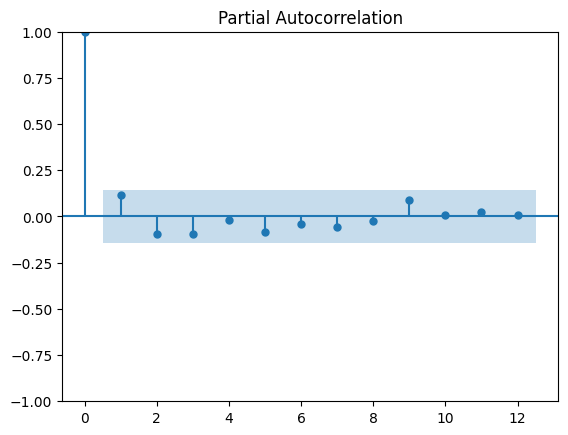

In [30]:
plot_acf(freq, lags = 12)
plot_pacf(freq, lags = 12)
plt.show()

In [31]:
model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')


c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python311\Lib\site-packages\statsm

37.37883905841618

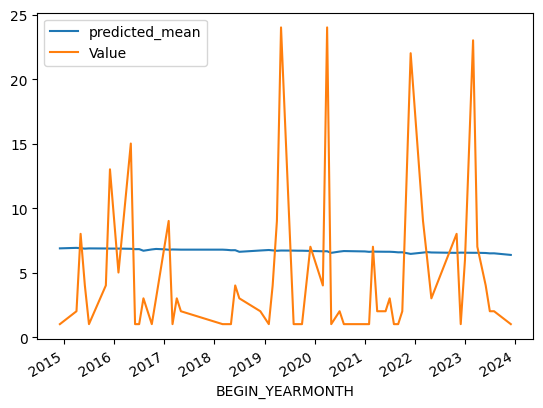

In [32]:
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE